<img src="../squeemos_blk.png" width=200 height=200 />

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns; sns.set()
import csv

from PIL import Image, ImageDraw
import os
import shutil

from mpl_toolkits.basemap import Basemap

#there is currently a bug in panda's scatter_matrix that produces a warning that has no affect on what I'm doin :)
import warnings
warnings.filterwarnings("ignore")

In [2]:
#load in the data
df = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False, delim_whitespace=True)
df.dropna(axis=0,how='any',subset=['Lat','Long'],inplace=True)

df_center = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_Reduced_Trackfile.txt',header=None,names=["Year","Month","Day","Hour","Lat","Long","Min_Pressure","Max_Winds","Unused"],low_memory=False,sep='\t')
df_center.dropna(axis=0,how='any',subset=['Lat','Long'],inplace=True)

df_time = pd.DataFrame()
df_time['cluster'] = 0

In [3]:
display(df.info())
display(df_center.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226789 entries, 0 to 226788
Data columns (total 10 columns):
Year                226789 non-null int64
Month               226789 non-null int64
Day                 226789 non-null int64
Hour                226789 non-null int64
Min                 226789 non-null int64
Sec                 226789 non-null float64
Lat                 226789 non-null float64
Long                226789 non-null float64
Dist_East_West      226789 non-null float64
Dist_North_South    226789 non-null float64
dtypes: float64(5), int64(5)
memory usage: 19.0 MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 9 columns):
Year            61 non-null int64
Month           61 non-null int64
Day             61 non-null int64
Hour            61 non-null int64
Lat             61 non-null float64
Long            61 non-null float64
Min_Pressure    61 non-null int64
Max_Winds       61 non-null int64
Unused          61 non-null int64
dtypes: float64(2), int64(7)
memory usage: 4.8 KB


None

In [4]:
#make a dataframe that contains strikes in time intervals
minutes_between = 30
cluster = 0

for x in range(len(df['Month'].unique())):
    month = df['Month'].unique()[x]
    for y in range(len(df[df['Month'] == df['Month'].unique()[x]]['Day'].unique())):
        day = df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]
        for z in range(len(df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique())):
            hour = df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique()[z]
            for w in range(0,60,minutes_between):
                minute = w
                aeon_sucks = df[(df['Month'] == month) & (df['Day'] == day) & (df['Hour'] == hour) & (df['Min'] >= minute) & (df['Min'] <= minute + minutes_between)]
                aeon_sucks['cluster'] = cluster
                df_time = df_time.append(aeon_sucks, ignore_index=True)
                cluster+=1

df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230720 entries, 0 to 230719
Data columns (total 11 columns):
Day                 230720 non-null float64
Dist_East_West      230720 non-null float64
Dist_North_South    230720 non-null float64
Hour                230720 non-null float64
Lat                 230720 non-null float64
Long                230720 non-null float64
Min                 230720 non-null float64
Month               230720 non-null float64
Sec                 230720 non-null float64
Year                230720 non-null float64
cluster             230720 non-null int64
dtypes: float64(10), int64(1)
memory usage: 19.4 MB


In [7]:
def kmeansify(num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++')
    
    for current_chunk in range(1,30): #range(1, df cluster max)
        df_inner = df_time.copy()
        df_inner['distance'] = np.sqrt((df_inner['Dist_East_West'] * df_inner['Dist_East_West']) + 
                                       (df_inner['Dist_North_South'] * df_inner['Dist_North_South']))
        df_inner = df_inner[(df_inner['distance'] <= 100) & (df_inner['cluster'] == current_chunk)]
        
        df_rainband = df_time.copy()
        df_rainband['distance'] = np.sqrt((df_rainband['Dist_East_West'] * df_rainband['Dist_East_West']) + 
                                       (df_rainband['Dist_North_South'] * df_rainband['Dist_North_South']))
        df_rainband = df_rainband[(df_rainband['distance'] >= 200) & (df_rainband['distance'] <= 400) & (df_rainband['cluster'] == current_chunk)]
        
        kmeans.fit(df_inner[['Lat', 'Long']])
        df_inner['cluster_label'] = kmeans.fit_predict(df_inner[['Lat', 'Long']])
        labels = kmeans.predict(df_inner[['Lat', 'Long']])
        centers = kmeans.cluster_centers_

        '''
        df_inner.plot.scatter(x='Lat',y='Long', c=labels, s=50, cmap='spring', figsize=(40,40))
        plt.scatter(centers[:, 0], centers[:, 1], c='black', s= 200, alpha=.5)
        plt.show()'''

        centers_df = pd.DataFrame(data=centers, columns=["Lat", "Long"])#, "delete"])
        centers_df = centers_df.iloc[:,:2]
        ln = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False,sep=' ')
        minLong_, minLat_, maxLong_, maxLat_ = ln['Long'].min(), ln['Lat'].min(), ln['Long'].max(), ln['Lat'].max()
        buffer = 10

        plt.figure(figsize=(20,20))
        m = Basemap(llcrnrlon=minLong_-buffer, llcrnrlat=minLat_-buffer,urcrnrlon=maxLong_+buffer,urcrnrlat=maxLat_+buffer,lon_0=0,lat_0=0)
        m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
        m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
        m.drawcoastlines(linewidth=0.1, color="white")

        # Plot the lightning data
        m.plot(centers_df['Long'], centers_df['Lat'], linestyle='none', marker="o", markersize=75, alpha=0.7, c="orange", markeredgecolor="black", markeredgewidth=1)
        plt.savefig("./data/kmeans/kmeans" + str(current_chunk) ,bbox_inches='tight')

,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance
1,27.0,-23.9866,64.2929,17.0,12.0782,-16.2206,56.0,8.0,19.4011,2017.0,1,68.621673
36,27.0,-24.7681,65.9164,17.0,12.0928,-16.2278,59.0,8.0,33.2243,2017.0,1,70.416124


,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance
49,27.0,-31.8026,66.1276,18.0,12.0947,-16.2925,1.0,8.0,19.4126,2017.0,2,73.377550
76,27.0,-17.1214,71.4205,18.0,12.1423,-16.1575,2.0,8.0,49.9460,2017.0,2,73.444061
104,27.0,-32.6965,63.9927,18.0,12.0755,-16.3007,4.0,8.0,35.0135,2017.0,2,71.861859
105,27.0,-30.3054,62.9363,18.0,12.0660,-16.2787,4.0,8.0,35.0135,2017.0,2,69.852667
166,27.0,-26.2720,65.6706,18.0,12.0908,-16.2972,8.0,8.0,43.8543,2017.0,2,70.730797
167,27.0,-22.5309,66.7714,18.0,12.1007,-16.2628,8.0,8.0,43.8543,2017.0,2,70.470287
177,27.0,-23.9972,68.5839,18.0,12.1170,-16.2763,9.0,8.0,45.2420,2017.0,2,72.660973
221,27.0,-28.4569,66.1932,18.0,12.0955,-16.3173,13.0,8.0,44.1413,2017.0,2,72.050919
239,27.0,-21.9782,62.7512,18.0,12.0647,-16.3129,15.0,8.0,16.4959,2017.0,2,66.488754
240,27.0,-27.7395,64.7082,18.0,12.0823,-16.3659,15.0,8.0,16.4959,2017.0,2,70.403345


,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance
461,27.0,-24.3260,56.6127,18.0,12.0096,-16.3893,31.0,8.0,14.1588,2017.0,3,61.617790
462,27.0,-24.9605,65.3082,18.0,12.0878,-16.3952,31.0,8.0,14.1588,2017.0,3,69.915574
513,27.0,-93.8891,-22.0752,18.0,11.3020,-17.0812,37.0,8.0,31.4158,2017.0,3,96.449352
514,27.0,-32.2982,56.4840,18.0,12.0085,-16.5171,37.0,8.0,35.7750,2017.0,3,65.066243
515,27.0,-26.1761,55.1052,18.0,11.9961,-16.4608,37.0,8.0,35.7750,2017.0,3,61.006322
522,27.0,-21.2678,59.1861,18.0,12.0328,-16.4157,38.0,8.0,18.9310,2017.0,3,62.891285
526,27.0,-20.1580,59.9756,18.0,12.0399,-16.4055,39.0,8.0,6.5884,2017.0,3,63.272566
527,27.0,-24.0011,54.6938,18.0,11.9924,-16.4408,39.0,8.0,6.6850,2017.0,3,59.728256
528,27.0,-18.4726,59.6976,18.0,12.0374,-16.3900,39.0,8.0,6.6850,2017.0,3,62.490322
589,27.0,-26.3836,54.1267,18.0,11.9873,-16.4627,44.0,8.0,52.7640,2017.0,3,60.214566


,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance
1008,27.0,-43.8095,11.47980,19.0,11.6036,-16.8369,17.0,8.0,29.1757,2017.0,4,45.288609
1085,27.0,-70.2087,-1.45214,19.0,11.4873,-17.0790,20.0,8.0,30.9636,2017.0,4,70.223716
1126,27.0,-79.4098,-24.89200,19.0,11.2765,-17.1629,23.0,8.0,8.0609,2017.0,4,83.219757
1183,27.0,-87.3315,-34.39670,19.0,11.1909,-17.2881,26.0,8.0,0.3192,2017.0,4,93.861195
1204,27.0,-68.2952,-18.28460,19.0,11.3358,-17.1139,27.0,8.0,22.3394,2017.0,4,70.700502
1205,27.0,-71.9806,-18.42910,19.0,11.3345,-17.1477,27.0,8.0,22.4249,2017.0,4,74.302345
1206,27.0,-79.1527,-17.70640,19.0,11.3410,-17.2135,27.0,8.0,22.6487,2017.0,4,81.108979
1210,27.0,-37.3191,10.82620,19.0,11.5976,-16.8301,27.0,8.0,42.6377,2017.0,4,38.857713
1211,27.0,-32.9508,11.20430,19.0,11.6010,-16.7900,27.0,8.0,42.6377,2017.0,4,34.803614
1276,27.0,-91.1487,-34.17430,19.0,11.1929,-17.3231,30.0,8.0,35.0284,2017.0,4,97.344585


,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance
1294,27.0,-91.1487,-34.17430,19.0,11.1929,-17.3231,30.0,8.0,35.0284,2017.0,5,97.344585
1322,27.0,-85.0843,-22.04300,19.0,11.3020,-17.2678,31.0,8.0,59.3040,2017.0,5,87.893299
1323,27.0,-80.8226,-22.71010,19.0,11.2960,-17.2287,31.0,8.0,59.3041,2017.0,5,83.952613
1354,27.0,-71.8680,-21.66490,19.0,11.3054,-17.1466,32.0,8.0,59.9171,2017.0,5,75.062489
1355,27.0,-72.2749,-23.17720,19.0,11.2918,-17.1503,32.0,8.0,59.9171,2017.0,5,75.900222
1377,27.0,-73.3880,-28.33660,19.0,11.2454,-17.1604,33.0,8.0,58.2621,2017.0,5,78.668681
1378,27.0,-77.8681,-27.38030,19.0,11.2540,-17.2015,33.0,8.0,58.2621,2017.0,5,82.541637
1386,27.0,-79.8477,-20.95330,19.0,11.3118,-17.2198,34.0,8.0,30.5903,2017.0,5,82.551172
1387,27.0,-75.6752,-22.42100,19.0,11.2986,-17.1815,34.0,8.0,30.5903,2017.0,5,78.926783
1388,27.0,-87.9561,-19.57450,19.0,11.3242,-17.2942,34.0,8.0,30.6948,2017.0,5,90.107916


,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance
2029,27.0,-79.8131,-38.2665,20.0,11.1556,-17.3755,3.0,8.0,43.0729,2017.0,6,88.512462
2030,27.0,-48.4598,-45.7499,20.0,11.0883,-17.0880,3.0,8.0,43.0729,2017.0,6,66.643871
2076,27.0,-81.4451,-40.5240,20.0,11.1351,-17.4419,6.0,8.0,1.5031,2017.0,6,90.969769
2168,27.0,-81.2194,-37.5773,20.0,11.1616,-17.4399,10.0,8.0,10.2649,2017.0,6,89.491030
2169,27.0,-81.3839,-33.5632,20.0,11.1977,-17.4415,10.0,8.0,10.2649,2017.0,6,88.033105
2170,27.0,-78.1266,-35.2645,20.0,11.1824,-17.4116,10.0,8.0,10.3548,2017.0,6,85.716688
2221,27.0,-86.2758,-39.6011,20.0,11.1434,-17.4862,12.0,8.0,55.8312,2017.0,6,94.930294
2222,27.0,-77.1673,-40.1237,20.0,11.1387,-17.4027,12.0,8.0,55.9536,2017.0,6,86.975304
2223,27.0,-79.3580,-39.2230,20.0,11.1468,-17.4228,12.0,8.0,56.0182,2017.0,6,88.521951
2224,27.0,-77.9750,-35.7648,20.0,11.1779,-17.4102,12.0,8.0,56.2279,2017.0,6,85.785905


,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance
2564,27.0,-50.0980,-56.38930,20.0,10.9920,-17.2564,31.0,8.0,44.9043,2017.0,7,75.429190
2612,27.0,-75.2414,-2.71548,20.0,11.4747,-17.4879,34.0,8.0,37.9268,2017.0,7,75.290385
2675,27.0,-74.7672,1.58942,20.0,11.5132,-17.5342,37.0,8.0,27.9634,2017.0,7,74.784092
2888,27.0,-65.8359,-2.61230,20.0,11.4752,-17.5024,47.0,8.0,28.7378,2017.0,7,65.887706
3041,27.0,-58.0821,9.26415,20.0,11.5818,-17.4814,55.0,8.0,7.7428,2017.0,7,58.816280
3042,27.0,-68.7756,10.87650,20.0,11.5963,-17.5796,55.0,8.0,8.2287,2017.0,7,69.630320
3102,27.0,-65.9506,12.64450,20.0,11.6122,-17.5537,57.0,8.0,41.7889,2017.0,7,67.151806
3103,27.0,-58.2673,15.07960,20.0,11.6341,-17.4832,57.0,8.0,41.8870,2017.0,7,60.186980


,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance
3183,27.0,-66.1730,10.520700,21.0,11.5931,-17.5557,1.0,8.0,31.0951,2017.0,8,67.004112
3218,27.0,-63.3554,14.101100,21.0,11.6253,-17.5299,4.0,8.0,3.0502,2017.0,8,64.905683
3219,27.0,-80.1225,16.280600,21.0,11.6449,-17.6839,4.0,8.0,3.0857,2017.0,8,81.759849
3323,27.0,-60.9409,9.397380,21.0,11.5828,-17.5573,10.0,8.0,0.6434,2017.0,8,61.661204
3324,27.0,-67.8851,6.973330,21.0,11.5610,-17.6210,10.0,8.0,0.7644,2017.0,8,68.242319
3325,27.0,-56.1779,10.931900,21.0,11.5966,-17.5136,10.0,8.0,0.8028,2017.0,8,57.231660
3393,27.0,-57.6917,-0.687999,21.0,11.4921,-17.5273,14.0,8.0,15.7846,2017.0,8,57.695802
3451,27.0,-66.7605,0.010863,21.0,11.4982,-17.6599,18.0,8.0,4.7432,2017.0,8,66.760501
3490,27.0,-60.2154,-7.517030,21.0,11.4305,-17.5997,20.0,8.0,24.0491,2017.0,8,60.682783
3491,27.0,-60.8463,-6.894340,21.0,11.4361,-17.6055,20.0,8.0,24.0906,2017.0,8,61.235644


,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance
3716,27.0,-62.7491,2.442490,21.0,11.5199,-17.6722,31.0,8.0,29.0750,2017.0,9,62.796619
3732,27.0,-62.2652,-0.748806,21.0,11.4912,-17.6677,32.0,8.0,15.4230,2017.0,9,62.269702
3733,27.0,-67.0563,0.841282,21.0,11.5055,-17.7117,32.0,8.0,15.5108,2017.0,9,67.061577
3749,27.0,-62.2738,-5.085410,21.0,11.4522,-17.6677,33.0,8.0,34.9486,2017.0,9,62.481098
3750,27.0,-62.3484,-4.251450,21.0,11.4597,-17.6684,33.0,8.0,35.0282,2017.0,9,62.493182
3815,27.0,-67.3884,4.338080,21.0,11.5368,-17.7636,38.0,8.0,20.3305,2017.0,9,67.527886
3816,27.0,-62.7688,-0.999275,21.0,11.4888,-17.7211,38.0,8.0,20.3835,2017.0,9,62.776754
3817,27.0,-63.0092,-1.310620,21.0,11.4860,-17.7233,38.0,8.0,20.3835,2017.0,9,63.022829
3818,27.0,-53.5498,24.497700,21.0,11.7181,-17.6369,38.0,8.0,20.4180,2017.0,9,58.887336
3917,27.0,-73.0302,0.412901,21.0,11.5015,-17.8153,44.0,8.0,8.5773,2017.0,9,73.031367


,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance
4135,27.0,-42.5873,13.83610,22.0,11.6220,-17.6328,1.0,8.0,2.0036,2017.0,10,44.778519
4154,27.0,-51.3779,19.69610,22.0,11.6747,-17.7136,2.0,8.0,57.1206,2017.0,10,55.023858
4169,27.0,-60.0463,52.59870,22.0,11.9706,-17.7938,3.0,8.0,50.3670,2017.0,10,79.825944
4217,27.0,-42.6445,16.18930,22.0,11.6431,-17.6813,12.0,8.0,32.3046,2017.0,10,45.614108
4239,27.0,-69.5882,-2.08809,22.0,11.4787,-17.9760,15.0,8.0,17.2688,2017.0,10,69.619521
4314,27.0,-69.7135,-54.75000,22.0,11.0051,-17.9761,23.0,8.0,25.7936,2017.0,10,88.642736
4315,27.0,-68.9028,-53.31560,22.0,11.0180,-17.9687,23.0,8.0,25.7936,2017.0,10,87.121461
4316,27.0,-78.9206,-57.15180,22.0,10.9835,-18.0604,23.0,8.0,25.8915,2017.0,10,97.441210


,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance
4464,27.0,-72.0559,37.5293,22.0,11.8350,-18.0469,33.0,8.0,57.4189,2017.0,11,81.243468
4532,27.0,-49.6787,68.5687,22.0,12.1142,-17.8889,39.0,8.0,21.1655,2017.0,11,84.673726
4538,27.0,-60.2855,59.8955,22.0,12.0362,-17.9863,40.0,8.0,35.4110,2017.0,11,84.981248
4539,27.0,-65.2767,65.0439,22.0,12.0825,-18.0323,40.0,8.0,35.4110,2017.0,11,92.150727
4540,27.0,-62.0384,64.1765,22.0,12.0747,-18.0025,40.0,8.0,35.6000,2017.0,11,89.260216
4559,27.0,-42.2143,65.3775,22.0,12.0855,-17.8202,42.0,8.0,10.9979,2017.0,11,77.822006
4576,27.0,-53.0909,64.5766,22.0,12.0784,-17.9671,45.0,8.0,15.8574,2017.0,11,83.598929
4577,27.0,-59.0376,65.0658,22.0,12.0828,-18.0218,45.0,8.0,15.9907,2017.0,11,87.857820
4605,27.0,-72.4739,66.2890,22.0,12.0938,-18.1454,48.0,8.0,40.6268,2017.0,11,98.217604
4629,27.0,-53.9351,66.7226,22.0,12.0977,-17.9749,51.0,8.0,4.9051,2017.0,11,85.795690


,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance
4739,27.0,-87.6214,38.6511,23.0,11.8454,-18.3306,1.0,8.0,59.6704,2017.0,12,95.767517
4813,27.0,-93.1717,21.8042,23.0,11.6941,-18.4275,8.0,8.0,39.9835,2017.0,12,95.689021
4816,27.0,-66.4122,54.4177,23.0,11.9874,-18.1824,9.0,8.0,4.1387,2017.0,12,85.859574
4817,27.0,-56.0777,49.3138,23.0,11.9415,-18.0873,9.0,8.0,4.1388,2017.0,12,74.676364
4853,27.0,-58.3878,41.7192,23.0,11.8732,-18.1084,11.0,8.0,21.2950,2017.0,12,71.760900
4883,27.0,-58.2673,53.3947,23.0,11.9782,-18.1075,13.0,8.0,4.8086,2017.0,12,79.032096
4900,27.0,-60.9412,43.6317,23.0,11.8904,-18.1319,14.0,8.0,14.5354,2017.0,12,74.950351
4901,27.0,-72.8956,49.6585,23.0,11.9446,-18.2419,14.0,8.0,14.7077,2017.0,12,88.202807
4902,27.0,-70.6535,45.4887,23.0,11.9071,-18.2212,14.0,8.0,14.8704,2017.0,12,84.030583
4916,27.0,-59.4752,40.9891,23.0,11.8669,-18.1645,15.0,8.0,32.2067,2017.0,12,72.231612


,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance
5161,27.0,-86.5304,17.8351,23.0,11.6590,-18.4584,30.0,8.0,24.5399,2017.0,13,88.349312
5229,27.0,-55.6789,41.7309,23.0,11.8739,-18.1755,34.0,8.0,57.1843,2017.0,13,69.581664
5312,27.0,-54.7890,44.5114,23.0,11.8993,-18.2130,40.0,8.0,3.6246,2017.0,13,70.591071
5403,27.0,-79.8596,14.8709,23.0,11.6332,-18.4881,46.0,8.0,15.5303,2017.0,13,81.232379
5404,27.0,-76.7706,13.2586,23.0,11.6187,-18.4597,46.0,8.0,15.5675,2017.0,13,77.907095
5460,27.0,-72.6806,29.4597,23.0,11.7644,-18.4225,49.0,8.0,44.0971,2017.0,13,78.424126
5526,27.0,-65.5506,39.4339,23.0,11.8541,-18.3572,52.0,8.0,29.1776,2017.0,13,76.497801
5527,27.0,-61.3602,39.7897,23.0,11.8573,-18.3187,52.0,8.0,29.1776,2017.0,13,73.132034
5528,27.0,-66.0611,39.9009,23.0,11.8583,-18.3619,52.0,8.0,29.2191,2017.0,13,77.176102
5577,27.0,-78.4338,33.3362,23.0,11.7998,-18.5206,55.0,8.0,53.5310,2017.0,13,85.224194


,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance
5709,28.0,-71.7250,38.3940,0.0,11.8459,-18.5040,5.0,8.0,36.9018,2017.0,14,81.354624
5710,28.0,-64.8408,41.3296,0.0,11.8723,-18.4408,5.0,8.0,37.1196,2017.0,14,76.892556
5745,28.0,-68.5391,37.1709,0.0,11.8349,-18.4747,8.0,8.0,23.8585,2017.0,14,77.969764
5746,28.0,-63.5656,37.1042,0.0,11.8343,-18.4290,8.0,8.0,24.1317,2017.0,14,73.602358
5767,28.0,-55.4550,38.5942,0.0,11.8477,-18.3545,9.0,8.0,14.9656,2017.0,14,67.563076
5806,28.0,-81.4346,53.6722,0.0,11.9833,-18.5936,11.0,8.0,56.5482,2017.0,14,97.531016
5825,28.0,-69.8988,37.4600,0.0,11.8375,-18.4872,13.0,8.0,7.5557,2017.0,14,79.303807
5826,28.0,-62.5276,39.1057,0.0,11.8523,-18.4195,13.0,8.0,7.6170,2017.0,14,73.749282
5839,28.0,-74.7938,29.5429,0.0,11.7663,-18.5320,14.0,8.0,8.9904,2017.0,14,80.417010
5840,28.0,-69.1849,25.9402,0.0,11.7339,-18.4804,14.0,8.0,8.9904,2017.0,14,73.888053


,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance
6146,28.0,-67.2145,27.0994,0.0,11.7458,-18.5515,33.0,8.0,5.5272,2017.0,15,72.471832
6147,28.0,-65.3895,40.4761,0.0,11.8661,-18.5350,33.0,8.0,5.5813,2017.0,15,76.903195
6184,28.0,-70.1552,47.4960,0.0,11.9301,-18.6232,35.0,8.0,30.0905,2017.0,15,84.720848
6233,28.0,-57.7235,34.2861,0.0,11.8113,-18.5087,39.0,8.0,12.8596,2017.0,15,67.138209
6234,28.0,-60.9668,39.8236,0.0,11.8611,-18.5386,39.0,8.0,12.8596,2017.0,15,72.820806
6235,28.0,-55.9042,41.1245,0.0,11.8728,-18.4921,39.0,8.0,13.0043,2017.0,15,69.401038
6236,28.0,-49.7708,38.8117,0.0,11.8520,-18.4357,39.0,8.0,13.0043,2017.0,15,63.114821
6264,28.0,-46.0014,41.4470,0.0,11.8757,-18.4011,40.0,8.0,45.7807,2017.0,15,61.919162
6265,28.0,-56.5437,42.4589,0.0,11.8848,-18.4980,40.0,8.0,45.8242,2017.0,15,70.710312
6266,28.0,-54.3590,41.1023,0.0,11.8726,-18.4779,40.0,8.0,45.8589,2017.0,15,68.149101


,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,cluster,distance


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

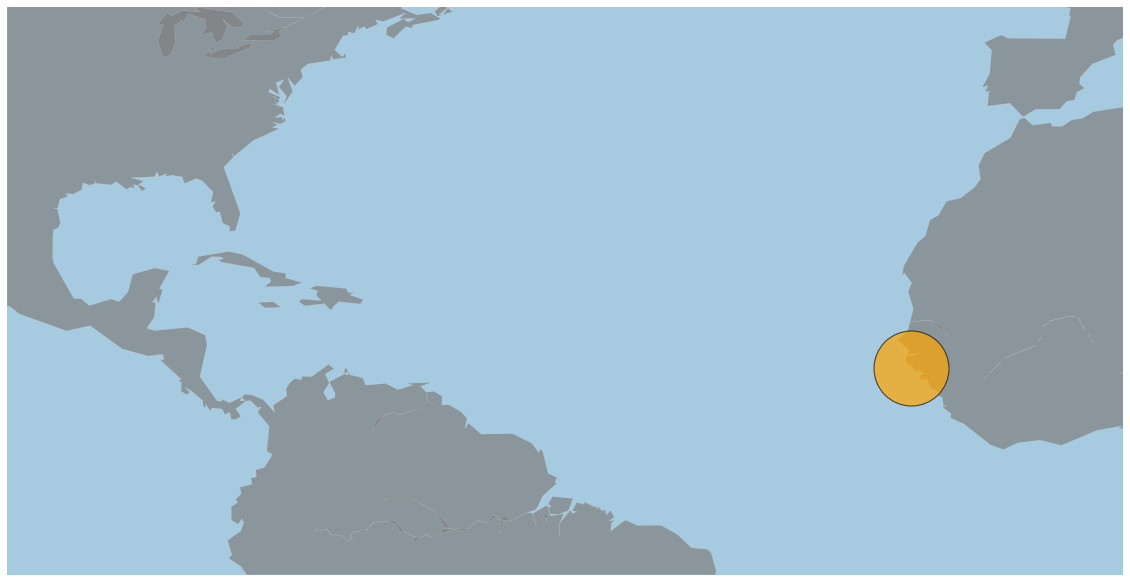

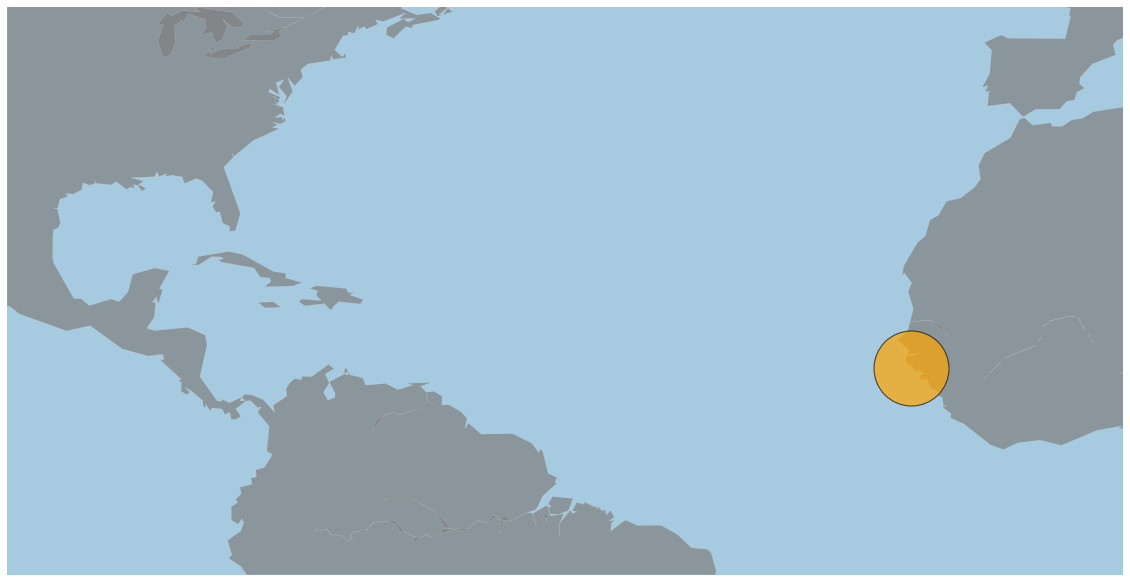

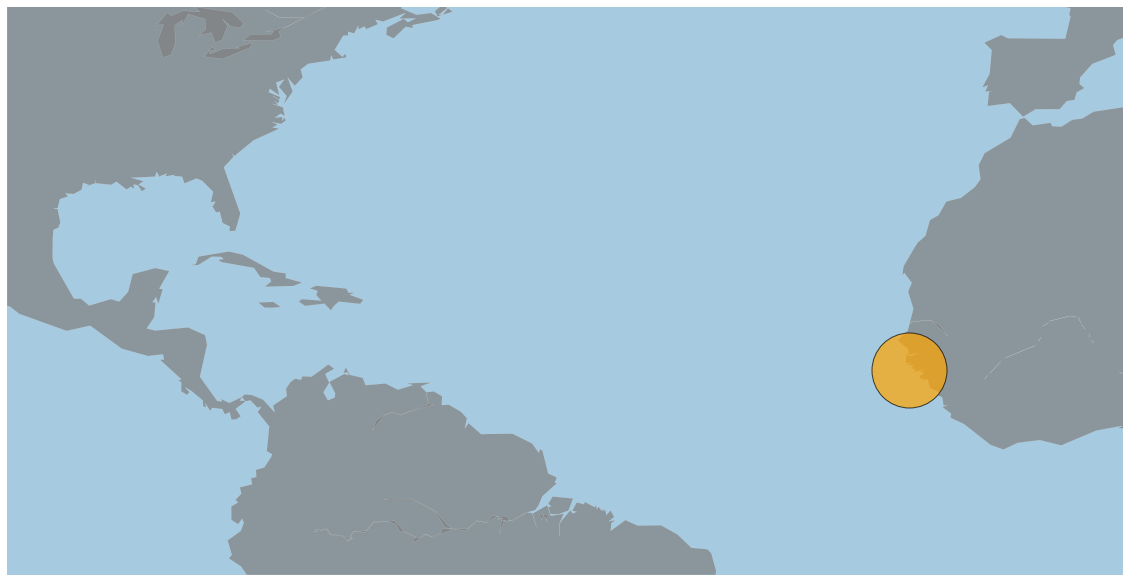

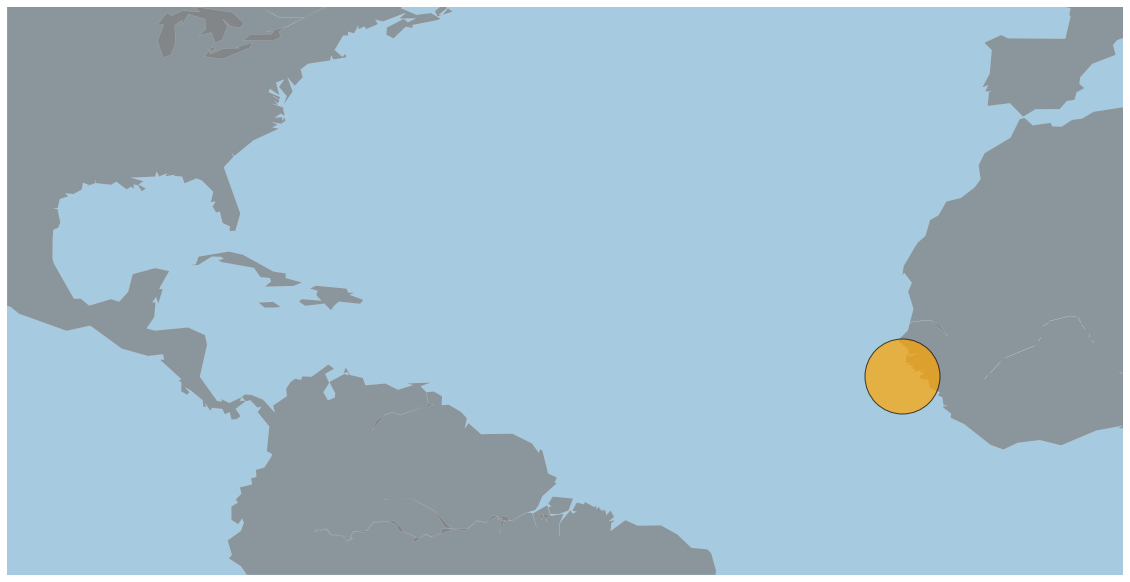

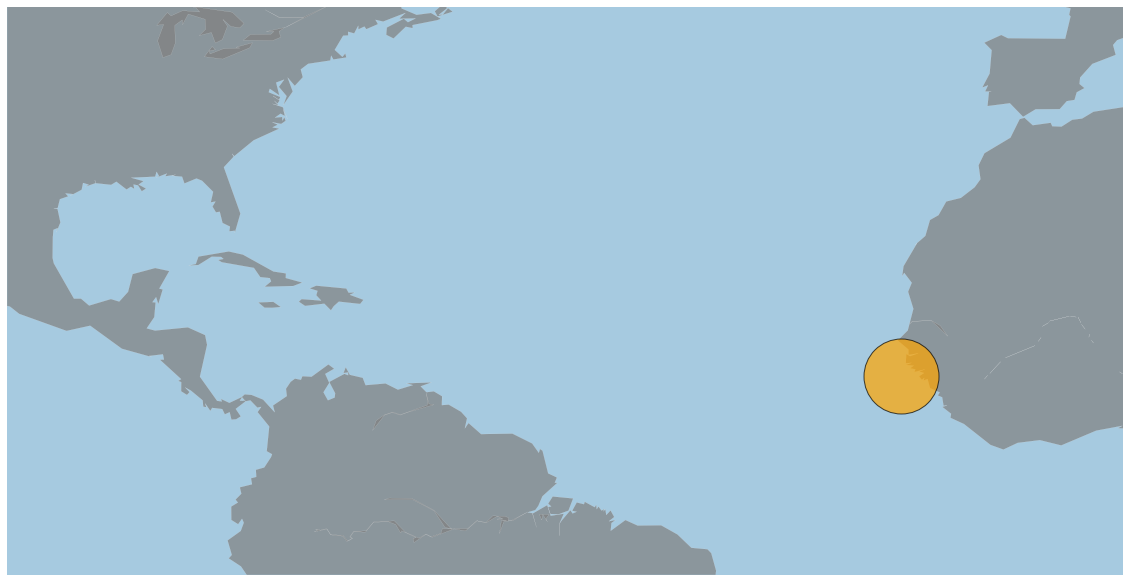

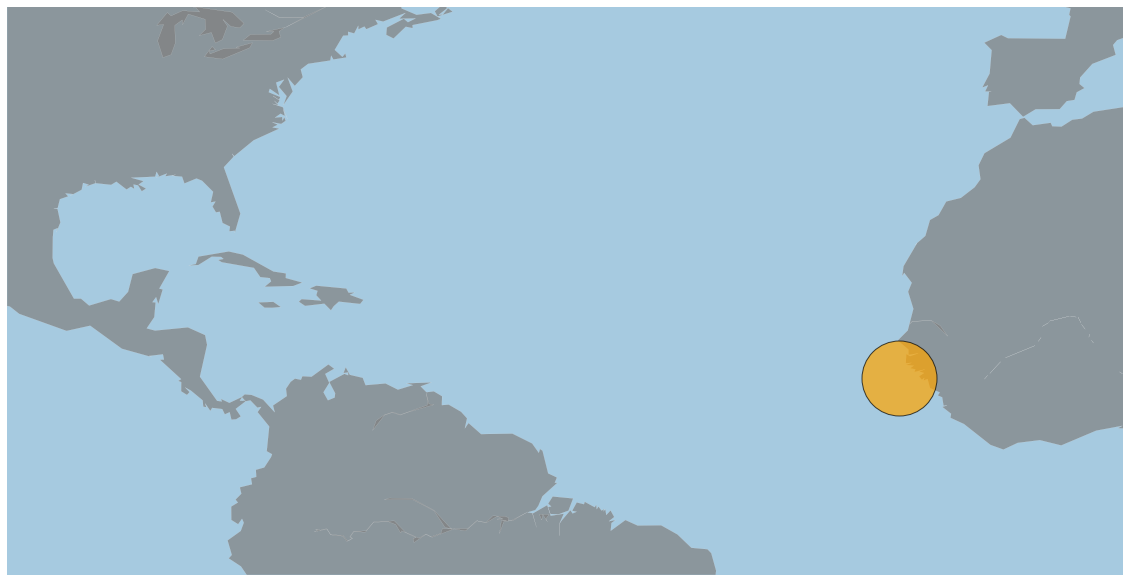

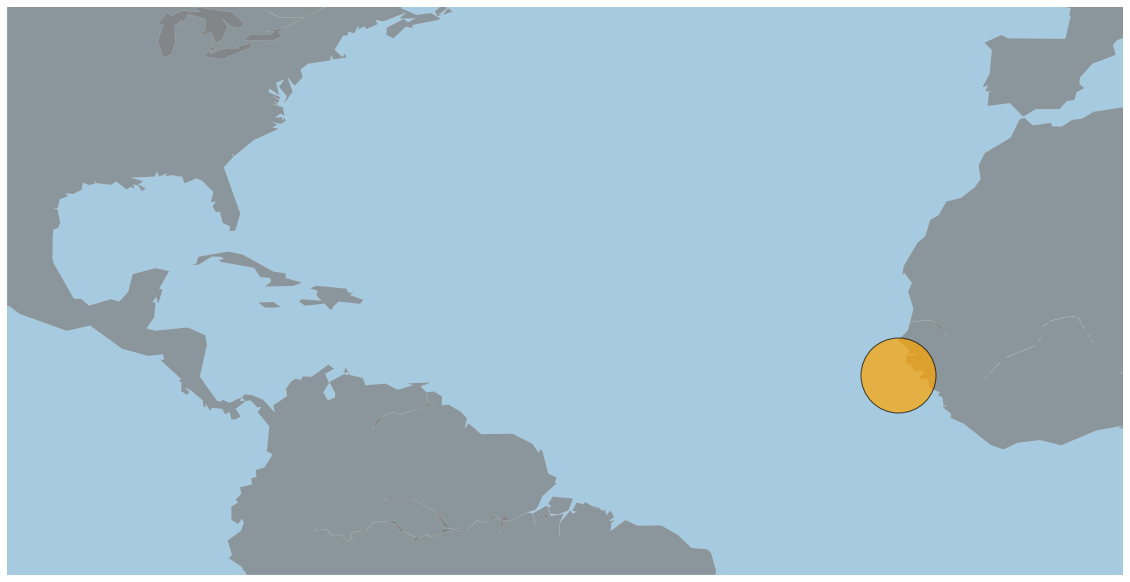

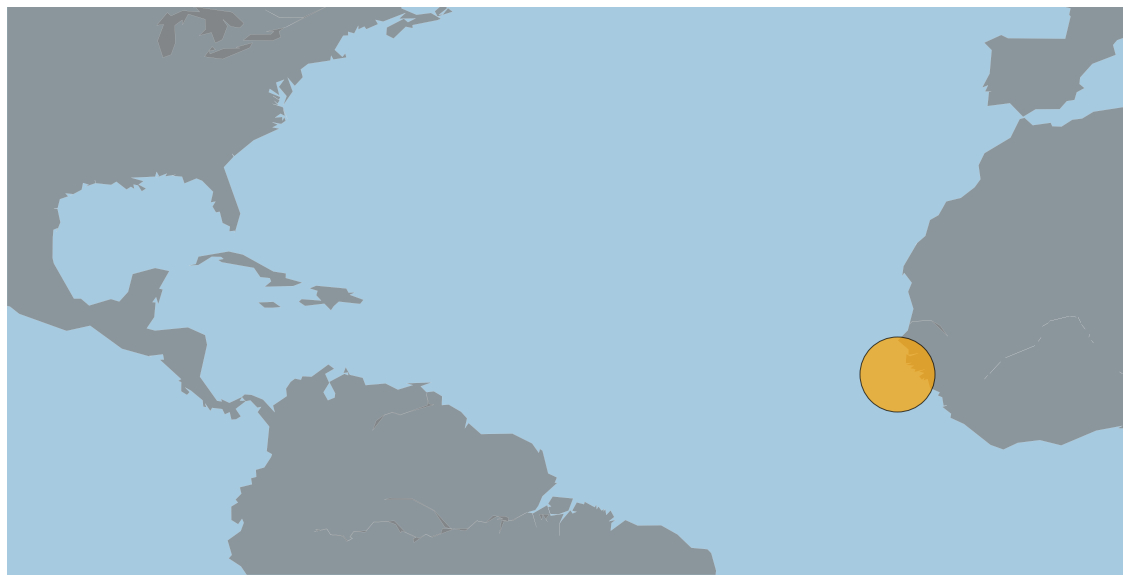

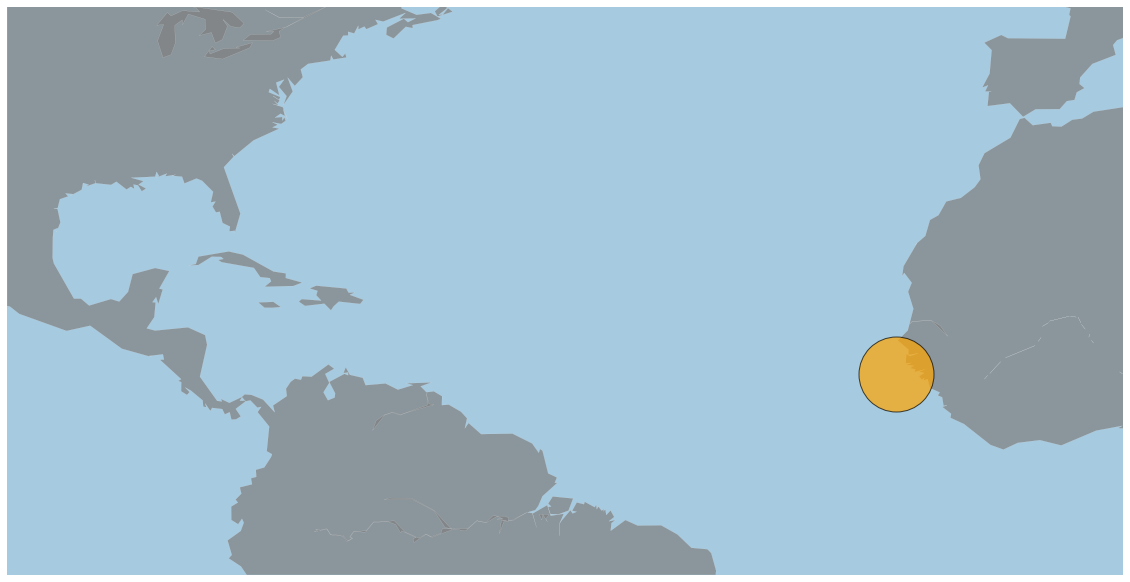

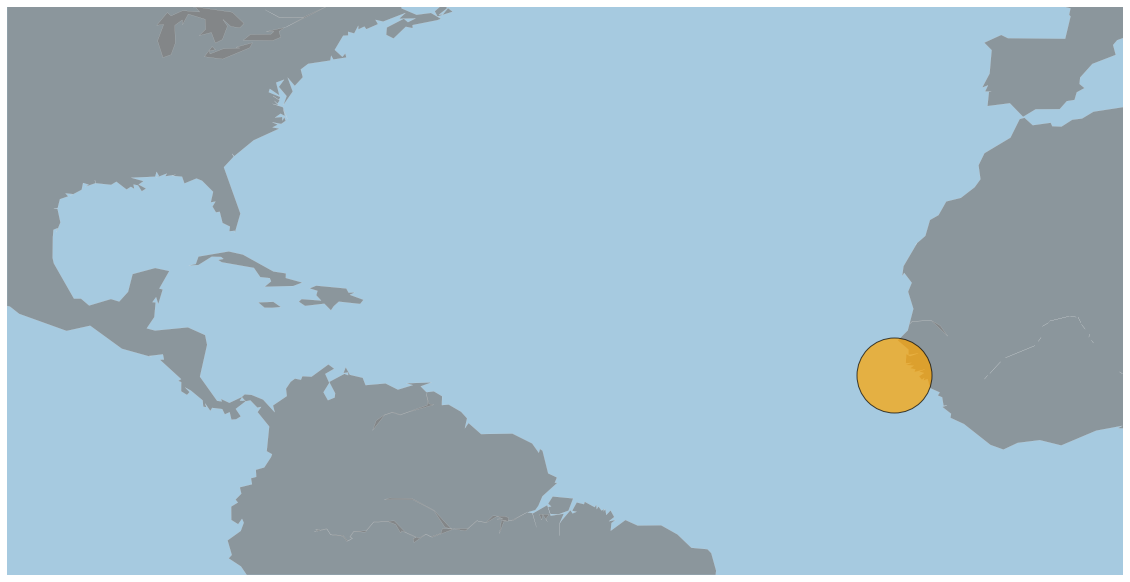

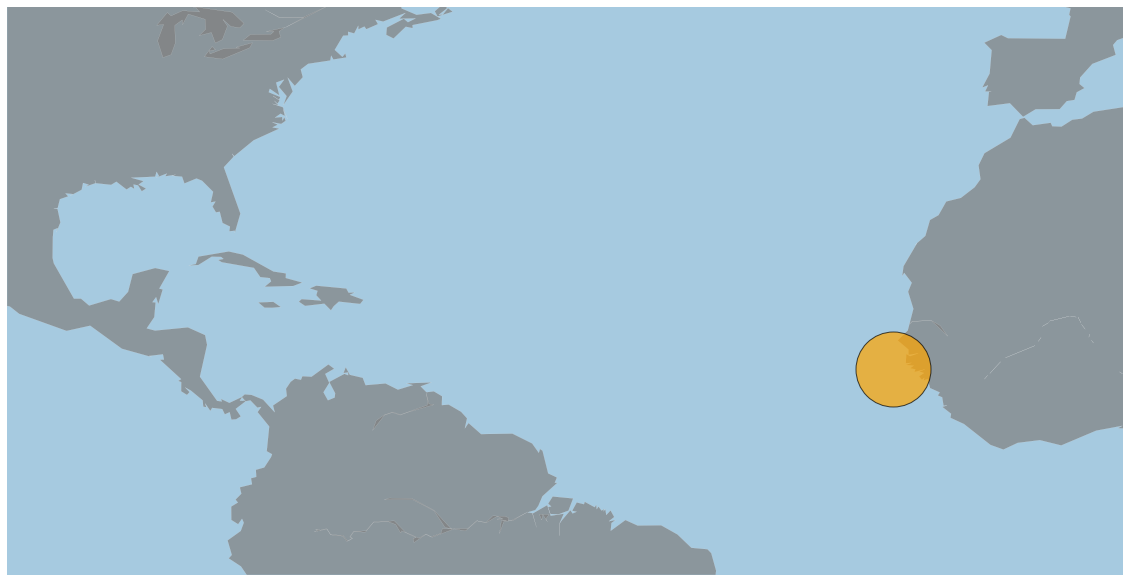

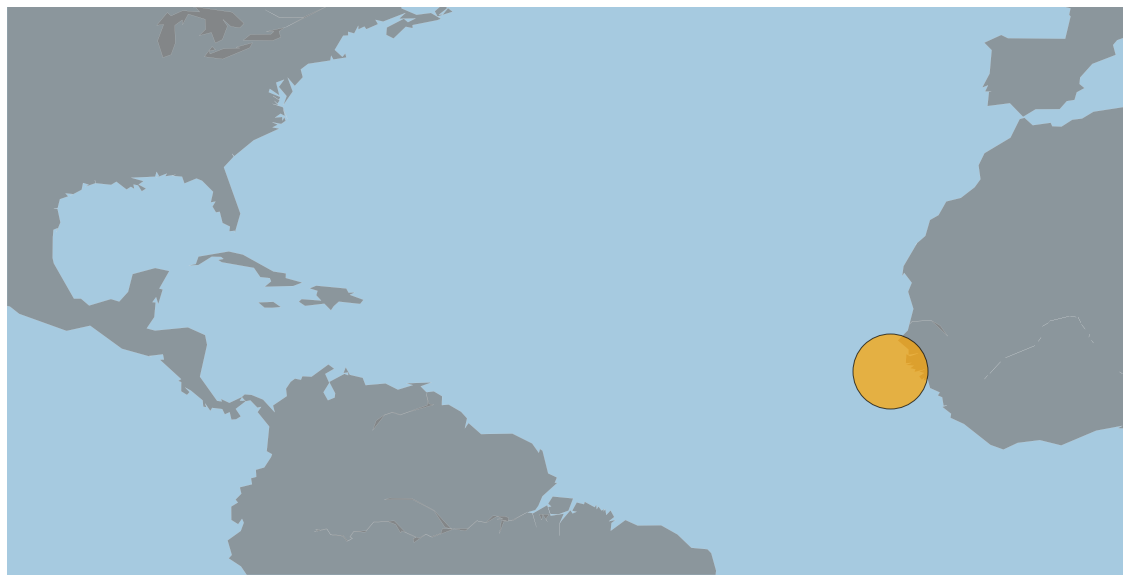

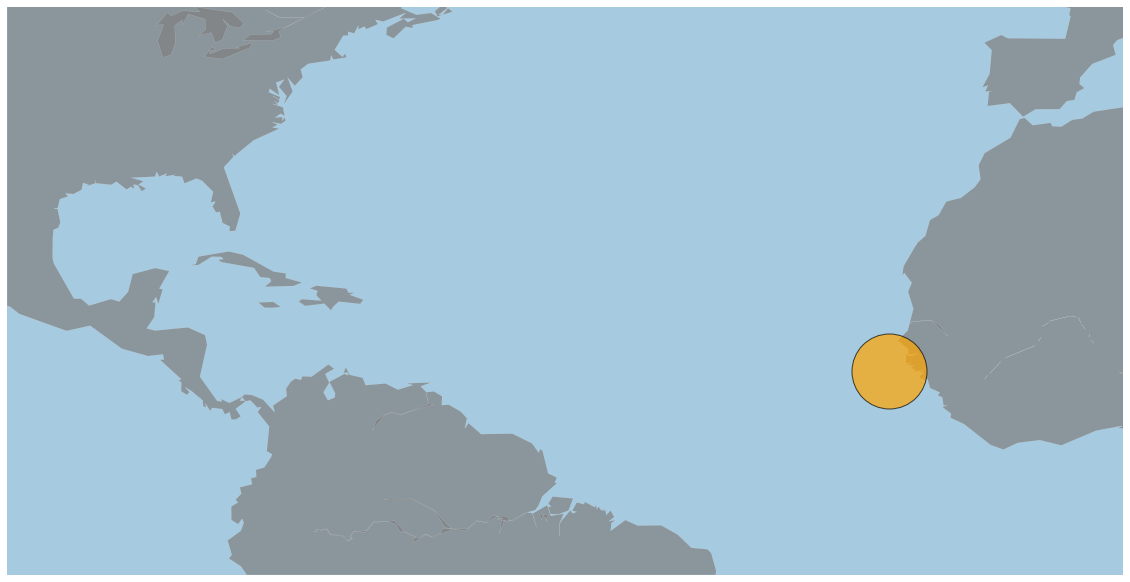

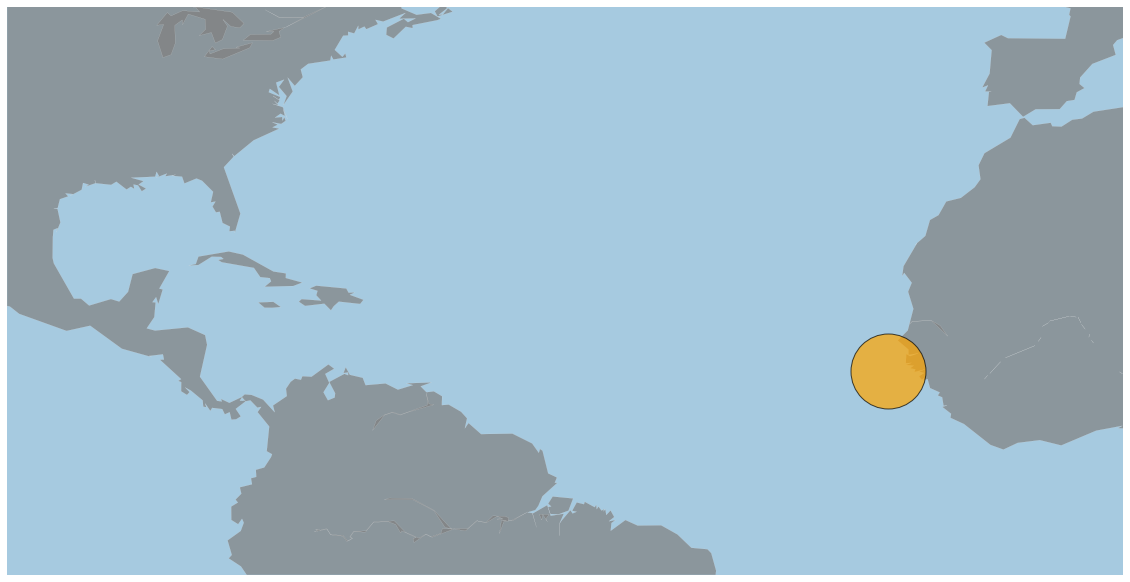

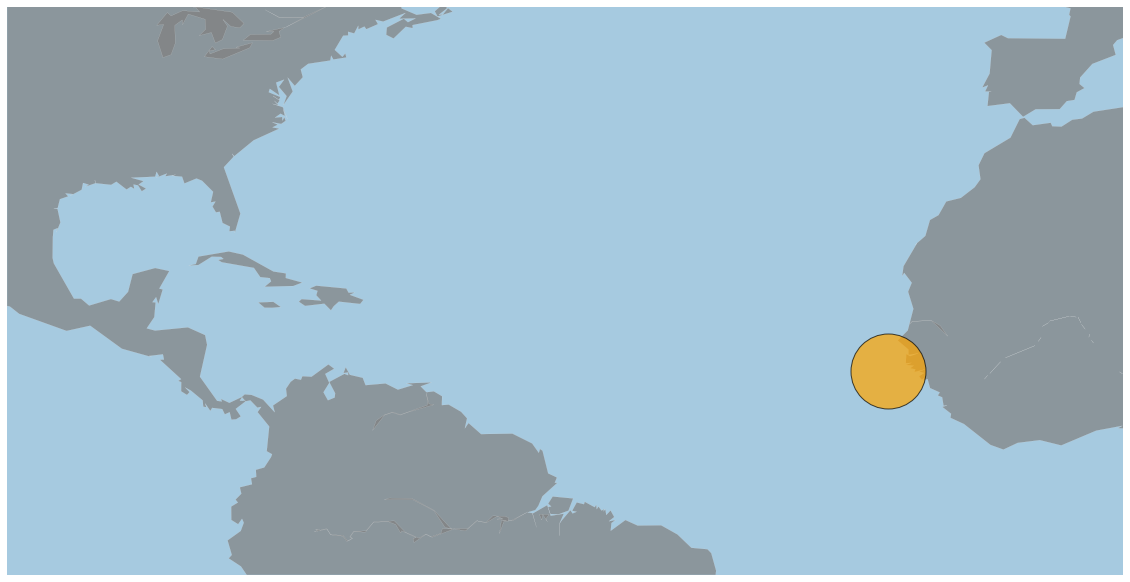

In [8]:
kmeansify(1)

In [12]:
images = []

for filename in os.listdir("./data/kmeans/"):
    if filename.endswith(".png"):
        images.append(Image.open("data/kmeans/" + filename))
    
images[0].save('test.gif', save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)

In [ ]:
#DEPRECATED
'''#elbow graph for visual estimation of ideal cluster count
clusters = range(1,16)

kmeans = [KMeans(n_clusters=i) for i in clusters]

y = df[['Lat']]
x = df[['Long']]

score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]

plt.plot(clusters, score)

plt.show()'''

'''#kmeans using the set cluster count
kmeans = KMeans(n_clusters=4, init='k-means++')
cluster_df = coord_df
kmeans.fit(cluster_df)
cluster_df['cluster'] = kmeans.fit_predict(cluster_df)
inertia = kmeans.inertia_
labels = kmeans.predict(cluster_df[cluster_df.columns[:2]])
centers = kmeans.cluster_centers_

cluster_df.plot.scatter(x='Lat',y='Long', c=labels, s=50, cmap='spring', figsize=(20,20))
plt.scatter(centers[:, 0], centers[:, 1], c='black', s= 200, alpha=.5)

plt.show()'''

'''for n_clusters in range(1,16):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
        kmeans.fit(cluster_df)
        inertia = kmeans.inertia_
        print("Cluster count: ", n_clusters, "\tInertia: ", inertia)
        '''